In [ ]:
import os
os.chdir('../../')

In [2]:
import pandas as pd
import numpy as np
from numpy.random import randn
from math import radians, sin, cos, sqrt, asin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2024-04-05 16:55:24.163994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from data_pipeline import Pipeline

In [4]:
df = pd.read_csv('data/CreditCardFraudFourYears.csv')

In [5]:
pipeline = Pipeline()
transformed_df = pipeline.transform(df)

In [30]:
features = [col for col in transformed_df.columns if col != target]

print(transformed_df[features].dtypes)

total_daily_fraud_transactions      int64
hour_0                              int64
hour_1                              int64
hour_2                              int64
hour_3                              int64
hour_4                              int64
hour_5                              int64
hour_6                              int64
hour_7                              int64
hour_8                              int64
hour_9                              int64
hour_10                             int64
hour_11                             int64
hour_12                             int64
hour_13                             int64
hour_14                             int64
hour_15                             int64
hour_16                             int64
hour_17                             int64
hour_18                             int64
hour_19                             int64
hour_20                             int64
hour_21                             int64
hour_22                           

In [37]:
split_idx = int(len(transformed_df) * 0.8)

split_idx = transformed_df.index[split_idx]
print(str(split_idx))

2021-12-31 00:00:00


In [119]:
from sklearn.preprocessing import MinMaxScaler

train = transformed_df.loc[transformed_df.index <= split_date]
test = transformed_df.loc[transformed_df.index > split_date]

target = 'total_daily_transactions'
features = [col for col in transformed_df.columns if col != target]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train_reshaped = X_train_reshaped.astype('float32')
X_test_reshaped = X_test_reshaped.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [120]:
print(X_train_reshaped.shape)

(1461, 1, 31)


In [121]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               52800     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 52901 (206.64 KB)
Trainable params: 52901 (206.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [142]:
history = model.fit(X_train_reshaped, y_train, epochs=400, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=0)

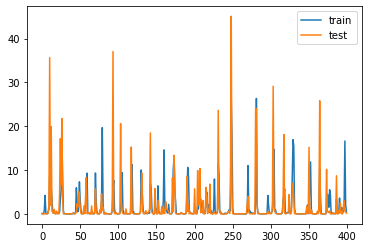

12/12 [==============================] - 0s 2ms/step


In [143]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

predicted_transactions = model.predict(X_test_reshaped)

predicted_transactions = predicted_transactions.flatten()

                 Date  Actual_Transactions  Predicted_Transactions
trans_date                                                        
2022-01-01 2022-01-01               2031.0             2030.583496
2022-01-02 2022-01-02               2023.0             2022.604248
2022-01-03 2022-01-03                986.0              985.364563
2022-01-04 2022-01-04                962.0              961.345032
2022-01-05 2022-01-05               1145.0             1144.416626
...               ...                  ...                     ...
2022-12-27 2022-12-27               2830.0             2829.681152
2022-12-28 2022-12-28               3153.0             3152.758545
2022-12-29 2022-12-29               3093.0             3092.828857
2022-12-30 2022-12-30               4701.0             4701.159668
2022-12-31 2022-12-31               5647.0             5647.407227

[365 rows x 3 columns]


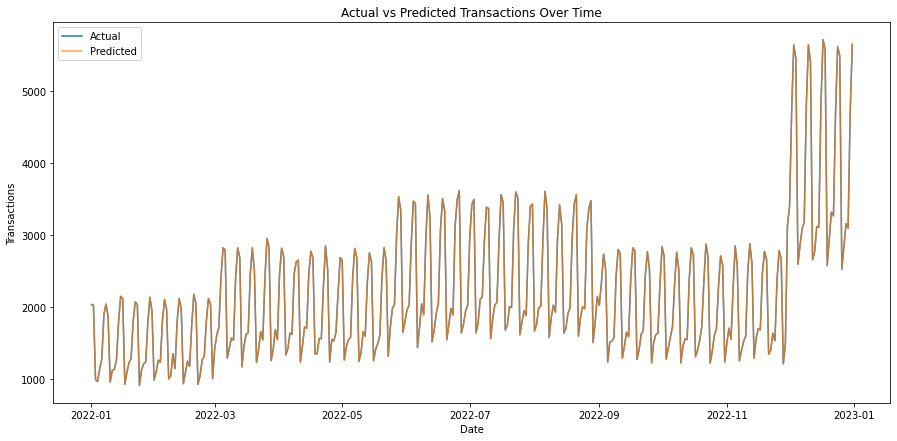

In [145]:
predicted_transactions = predicted_transactions.flatten()

assert len(predicted_transactions) == len(y_test)

results_df = pd.DataFrame({
    'Date': test.index, 
    'Actual_Transactions': y_test,
    'Predicted_Transactions': predicted_transactions
})

results_df['Date'] = pd.to_datetime(results_df['Date'])
results_df.to_csv('p1dm.csv')

print(results_df)

plt.figure(figsize=(15, 7))
plt.plot(results_df['Date'].values, results_df['Actual_Transactions'].values, label='Actual')
plt.plot(results_df['Date'].values, results_df['Predicted_Transactions'].values, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.show()
